# **EfficientNet**

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 645s 1s/step - accuracy: 0.1624 - loss: 1.9865 - val_accuracy: 0.2494 - val_loss: 1.9419
Epoch 2/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.2019 - loss: 1.8875 - val_accuracy: 0.2951 - val_loss: 1.8499
Epoch 3/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - accuracy: 0.2550 - loss: 1.8350 - val_accuracy: 0.2527 - val_loss: 1.8462
Epoch 4/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 542s 1s/step - accuracy: 0.2657 - loss: 1.8291 - val_accuracy: 0.3268 - val_loss: 1.7543
Epoch 5/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 541s 1s/step - accuracy: 0.3043 - loss: 1.7784 - val_accuracy: 0.3009 - val_loss: 1.8118
Epoch 6/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 542s 1s/step - accuracy: 0.3100 - loss: 1.7460 - val_accuracy: 0.3293 - val_loss: 1.7205
Epoch 7/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 541s 1s/step - accuracy: 0.3329 - loss: 1.7106 - val_accuracy: 0.3678 - val_loss: 1.6508
Epoch 8/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 540s 1s/step - accuracy: 0.3251 - loss: 1.6998 - val_accuracy: 0.365

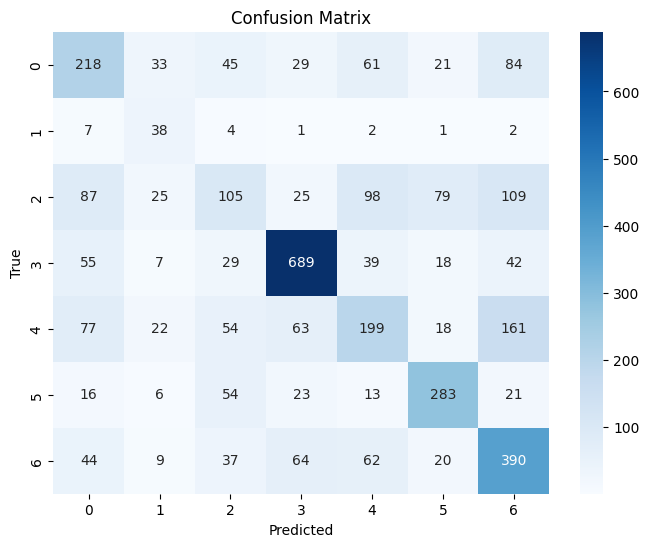

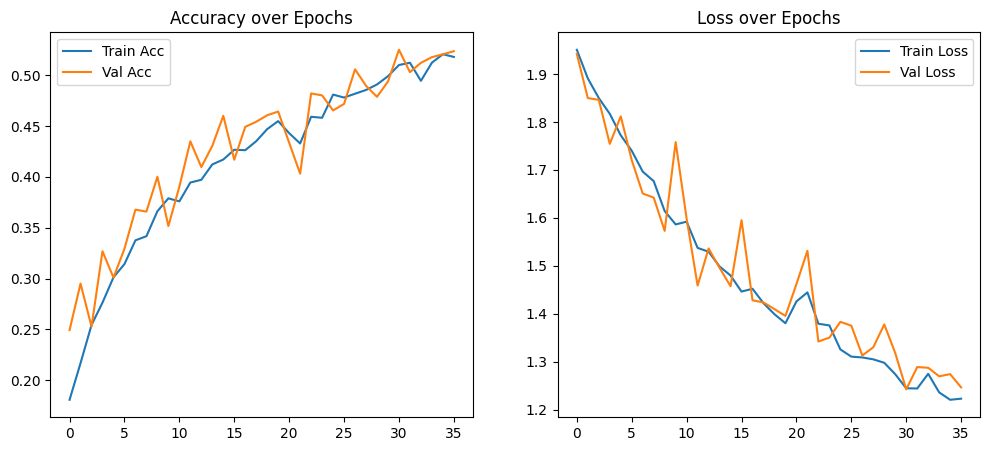

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

data = pd.read_csv("/content/fer2013.csv")
data = data[data['pixels'].apply(lambda x: len(x.split()) == 2304)]

X = np.array([np.fromstring(pix, sep=' ').reshape(48, 48, 1) for pix in data['pixels']])
X = X / 255.0  # Normalize to [0,1]
y = to_categorical(data['emotion'].astype(int), num_classes=7)

# Convert grayscale to RGB
X_rgb = np.repeat(X, 3, axis=-1)

# Split based on 'Usage' column
usage = data['Usage'].values
X_train = X_rgb[usage == 'Training']
y_train = y[usage == 'Training']
X_val = X_rgb[usage == 'PublicTest']
y_val = y[usage == 'PublicTest']
X_test = X_rgb[(usage != 'Training') & (usage != 'PublicTest')]
y_test = y[(usage != 'Training') & (usage != 'PublicTest')]

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Weighted loss to handle imbalance
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))))

# Build model with EfficientNetB0
base_model = EfficientNetB0(include_top=False, input_shape=(48, 48, 3), weights=None)

input_layer = Input(shape=(48, 48, 3))
x = base_model(input_layer, training=True)
x = GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
output = layers.Dense(7, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=60,
    class_weight=class_weights,
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluation
y_pred_logits = model.predict(X_test)
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()


# **EfficientNet-B0 + ArcFace**

**Dataset & DataLoader**

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Custom Dataset từ fer2013.csv
class FER2013Custom(Dataset):
    def __init__(self, csv_file, usage, transform=None):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.loc[idx, 'pixels']
        label = int(self.data.loc[idx, 'emotion'])
        image = np.array([int(p) for p in pixels.split()], dtype=np.uint8).reshape(48, 48)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image.convert("RGB"))
        return image, label

# Transform
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Tạo dataset
csv_path = '/content/fer2013.csv'

train_dataset = FER2013Custom(csv_path, usage='Training', transform=train_transforms)
val_dataset = FER2013Custom(csv_path, usage='PublicTest', transform=val_transforms)
test_dataset = FER2013Custom(csv_path, usage='PrivateTest', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Số mẫu trong tập huấn luyện: 28709
Số mẫu trong tập validation: 3589
Số mẫu trong tập test: 3589


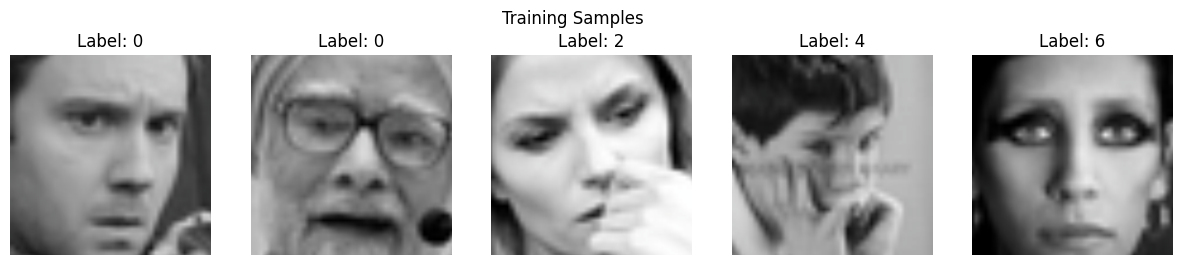

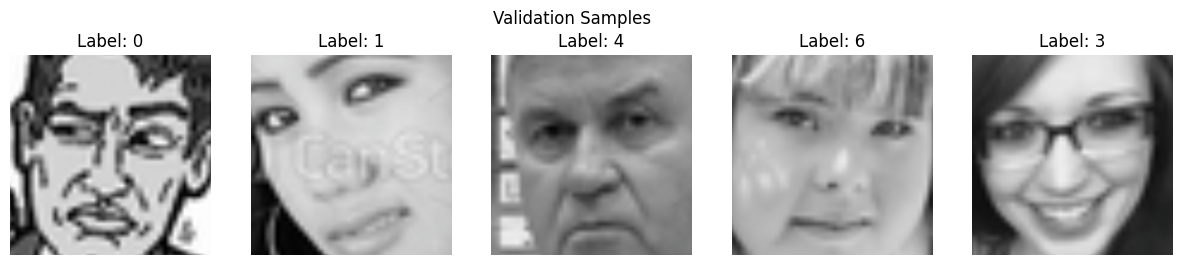

In [ ]:
import matplotlib.pyplot as plt

# In số lượng mẫu mỗi tập
print("Số mẫu trong tập huấn luyện:", len(train_dataset))
print("Số mẫu trong tập validation:", len(val_dataset))
print("Số mẫu trong tập test:", len(test_dataset))

# Hiển thị một vài ảnh mẫu và nhãn
def show_samples(dataset, title=""):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # đổi từ [C,H,W] sang [H,W,C]
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # unnormalize
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Gọi hàm hiển thị
show_samples(train_dataset, title="Training Samples")
show_samples(val_dataset, title="Validation Samples")



In [ ]:
# Lấy 1 batch thử
images, labels = next(iter(train_loader))
print("Kích thước ảnh:", images.shape)  # [batch_size, 3, 224, 224]
print("Label batch:", labels[:10])      # In 10 label đầu tiên

Kích thước ảnh: torch.Size([64, 3, 224, 224])
Label batch: tensor([2, 3, 5, 2, 0, 4, 6, 4, 6, 2])


**Mô hình EfficientNet + ArcFace**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import math

# ArcFace Layer
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.s = s
        self.m = m
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, x, labels):
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - cosine**2 + 1e-6)
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

# EfficientNet-B0 + ArcFace
class FER_EfficientNet_ArcFace(nn.Module):
    def __init__(self, num_classes=7, embed_dim=512):
        super().__init__()
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.backbone.classifier = nn.Identity()  # Bỏ classifier gốc

        self.embedding = nn.Linear(1280, embed_dim)  # EfficientNet-B0 output là 1280
        self.arc_margin = ArcMarginProduct(embed_dim, num_classes)

    def forward(self, x, labels=None):
        features = self.backbone(x)
        features = self.embedding(features)

        if labels is not None:
            logits = self.arc_margin(features, labels)
        else:
            # inference mode
            logits = F.linear(F.normalize(features), F.normalize(self.arc_margin.weight)) * self.arc_margin.s
        return logits


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FER_EfficientNet_ArcFace().to(device)

# Kiểm tra 1 batch
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images, labels)
print("Output logits shape:", outputs.shape)  # [batch_size, 7]


Output logits shape: torch.Size([64, 7])


**Training + Validation vòng lặp**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import numpy as np

# ==== Tính class weights (không bỏ lớp nào) ====
def compute_class_weights(labels, num_classes):
    counts = Counter(labels)
    total = sum(counts.values())
    weights = [total / (num_classes * counts.get(i, 1)) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float32)

# ==== Tạo sampler để oversample lớp hiếm ====
def get_sampler(labels):
    class_count = Counter(labels)
    class_weights = {cls: 1.0 / count for cls, count in class_count.items()}
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(labels), replacement=True)
    return sampler

# ==== Lấy toàn bộ nhãn trong train_dataset (dùng index chuẩn) ====
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]  # đảm bảo không lỗi index

# ==== Chuẩn bị dữ liệu + DataLoader ====
num_classes = 7
class_weights = compute_class_weights(train_labels, num_classes).to(device)
sampler = get_sampler(train_labels)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ==== Loss, Optimizer, Scheduler ====
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# ==== Hàm đánh giá ====
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total if total > 0 else 0

# ==== Training loop ====
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    val_acc = evaluate(model, val_loader)
    avg_loss = running_loss / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%",)


Epoch 1/30 - Loss: 5.6806, Val Acc: 43.97%
Epoch 2/30 - Loss: 4.1592, Val Acc: 43.74%
Epoch 3/30 - Loss: 3.2007, Val Acc: 45.53%
Epoch 4/30 - Loss: 3.0862, Val Acc: 53.58%
Epoch 5/30 - Loss: 2.9551, Val Acc: 56.90%
Epoch 6/30 - Loss: 2.8571, Val Acc: 57.76%
Epoch 7/30 - Loss: 2.8215, Val Acc: 58.65%
Epoch 8/30 - Loss: 2.7946, Val Acc: 58.82%
Epoch 9/30 - Loss: 2.7467, Val Acc: 58.57%
Epoch 10/30 - Loss: 2.7557, Val Acc: 60.96%
Epoch 11/30 - Loss: 2.7731, Val Acc: 60.69%
Epoch 12/30 - Loss: 2.7562, Val Acc: 60.52%
Epoch 13/30 - Loss: 2.6620, Val Acc: 61.33%
Epoch 14/30 - Loss: 2.6952, Val Acc: 62.13%
Epoch 15/30 - Loss: 2.6554, Val Acc: 61.30%
Epoch 16/30 - Loss: 2.6810, Val Acc: 61.94%
Epoch 17/30 - Loss: 2.6455, Val Acc: 61.24%
Epoch 18/30 - Loss: 2.6557, Val Acc: 61.80%
Epoch 19/30 - Loss: 2.6814, Val Acc: 61.69%
Epoch 20/30 - Loss: 2.5963, Val Acc: 63.08%
Epoch 21/30 - Loss: 2.6264, Val Acc: 62.72%
Epoch 22/30 - Loss: 2.6266, Val Acc: 62.02%
Epoch 23/30 - Loss: 2.6353, Val Acc: 62.6

In [ ]:
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 65.56%


**Đánh giá chi tiết – Confusion Matrix, F1 Score, Precision**

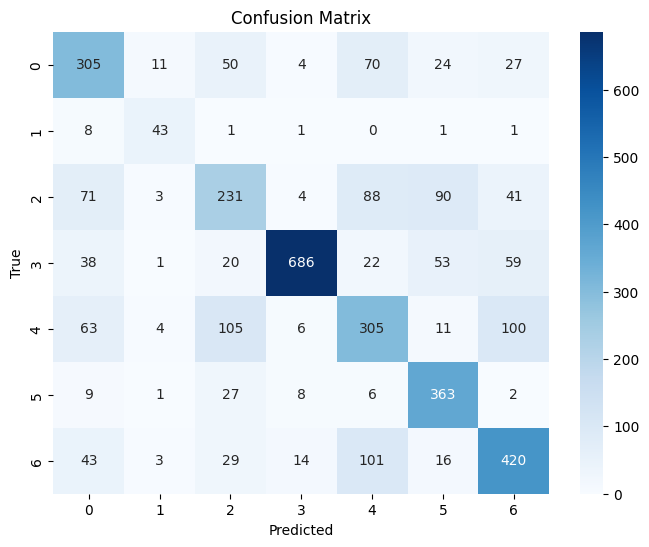

              precision    recall  f1-score   support

           0     0.5680    0.6212    0.5934       491
           1     0.6515    0.7818    0.7107        55
           2     0.4989    0.4375    0.4662       528
           3     0.9488    0.7804    0.8564       879
           4     0.5152    0.5135    0.5143       594
           5     0.6505    0.8726    0.7454       416
           6     0.6462    0.6709    0.6583       626

    accuracy                         0.6556      3589
   macro avg     0.6399    0.6683    0.6493      3589
weighted avg     0.6668    0.6556    0.6568      3589



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- Hàm lấy toàn bộ dự đoán và nhãn thật ---
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

# --- Lấy dự đoán ---
preds, labels = get_predictions(model, test_loader)

# --- Confusion matrix ---
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- F1, Precision, Recall ---
print(classification_report(labels, preds, digits=4))
